It's time to fine-tune our WaveNet using the ResNet

In [1]:
colab = False

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

import os
import math
import time
import sys
import shutil
import copy
import IPython.display as ipd

import numpy as np

if colab:
  !pip install -q livelossplot
  !pip install -q kaldi_io
  !pip install -q kaldiio
  os.environ['KALDI_ROOT'] = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild'
else:
    os.environ['KALDI_ROOT'] = '/opt/kaldi/'

import kaldi_io
import kaldiio
#from livelossplot import PlotLosses
import librosa
from tqdm.notebook import tqdm
from pesq import pesq

In [2]:
from DWaveNet import DWaveNet
from datasets import SequenceDataset
from utils import ScheduledOptim, change_path_scp, EnergyConservingLoss, plot_modelPerformance, l1_mse_loss, splitAudio

In [3]:
train_dataset = SequenceDataset('../data/train/trainTOTAL.scp', '../data/utt2spkTOTAL.scp', min_length = 16000, colab = False)
test_dataset = SequenceDataset('../data/test/testTOTAL.scp', '../data/utt2spkTOTAL.scp', min_length = 16000, colab = False)
train_data = DataLoader(train_dataset, batch_size = 8, shuffle=True)
test_data = DataLoader(test_dataset, batch_size = 8, shuffle=True)

Totally 25334 samples with at most 247 samples for one class
Totally 5482 samples with at most 247 samples for one class


In [4]:
net = DWaveNet(in_channels = 1, target_field_length = None, num_layers = 30,
                 num_stacks = 3, residual_channels = 128,
                 gate_channels = 128, skip_out_channels = 128,
                 last_channels=(2048, 256))

In [5]:
if colab:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device
else:  
  os.environ["CUDA_VISIBLE_DEVICES"] = '4'
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device

In [14]:
#optim = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr = 0.001, eps = 1e-08, weight_decay=0.0)
optim = ScheduledOptim( # Transformer optimizer
        torch.optim.Adam(
            filter(lambda p: p.requires_grad,
                   net.parameters()),
            betas = (0.9, 0.98),
             eps = 1e-09,
              weight_decay = 1e-4,
               amsgrad = True),
                n_warmup_steps = 8000)

start_epoch = 1
best = {}
best['train'] = 100000
best['validation'] = 100000
best_epoch = -1
history = None

#pretrain_model_pth = "../log/denoising/wavenet3/model_best.pth.tar"
pretrain_model_pth = "../log/fine_tuning/wavenetLAB/model_best.pth.tar"

# if pretrain_model_pth is not None:
#     if os.path.isfile(pretrain_model_pth):
#         print('loading pre-trained model from %s' % pretrain_model_pth)
#         model_dict = net.state_dict()
#         checkpoint = torch.load(pretrain_model_pth, map_location = lambda storage, loc: storage) # load for cpu
#         net.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()})
#     else:
#         print("===> no checkpoint found at '{}'".format(pretrain_model_pth))
        
if pretrain_model_pth is not None:
    if os.path.isfile(pretrain_model_pth):
        print('loading pre-trained model from %s' % pretrain_model_pth)
        model_dict = net.state_dict()
        checkpoint = torch.load(pretrain_model_pth, map_location = lambda storage, loc: storage) # load for cpu
        
        start_epoch = checkpoint['epoch'] + 1
        best_epoch = checkpoint['epoch']
        best = checkpoint['best_losses']
        history = checkpoint['history']
        #print(checkpoint['state_dict'])
        #model.load_state_dict(checkpoint['state_dict'])
        
        net.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()})
        
        optim.load_state_dict(checkpoint['optimizer'])
    else:
        print("===> no checkpoint found at '{}'".format(pretrain_model_pth))
#         #exit()

loading pre-trained model from ../log/fine_tuning/wavenetLAB/model_best.pth.tar


In [7]:
import glob
from SpeakerNet import SpeakerNet
from DatasetLoader import DatasetLoader

In [8]:
# params
if colab:
    base_path = '/content/drive/My Drive/Stage-Imaging/'
else:
    base_path = '/opt/kaldi/egs/'
eval = True
model = 'ResNetSE34L'
trainfunc = 'angleproto'
save_path = '/content/drive/My Drive/Stage-Imaging/'
max_frames = 300
batch_size = 200
max_seg_per_spk = 100
nDataLoaderThread = 5
max_epoch = 500
optimizer = 'adam'
hard_prob = .5
hard_rank = 10
margin = 1
scale = 15
nSpeakers = 5994
if colab:
    test_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav/'
else:
    test_path = '/export/corpora/VoxCeleb1_test/wav/'
initial_model = 'baseline_lite_ap.model'
encoder_type = 'SAP'
nOut = 512
lr = 0.001


# defaults
lr_decay = .95
test_interval = 10

In [9]:
s = SpeakerNet(model = model, trainfunc = trainfunc, max_frames = max_frames, batch_size = batch_size, max_seg_per_spk = max_seg_per_spk, nDataLoaderThread = nDataLoaderThread, encoder_type = encoder_type, nOut = nOut,
               test_interval = test_interval, max_epoch = max_epoch, optimizer = optimizer, lr = lr, lr_decay = lr_decay, hard_prob = hard_prob, hard_rank = hard_rank, margin = margin, scale = scale,
               nSpeakers = nSpeakers)

it = 1
prevloss = float("inf")
sumloss = 0

Embedding size is 512, encoder SAP.
Initialised AngleProto


In [10]:
## Load model weights
modelfiles = glob.glob('%s/model0*.model'%save_path)
modelfiles.sort()

if len(modelfiles) >= 1:
    s.loadParameters(modelfiles[-1]);
    print("Model %s loaded from previous state!"%modelfiles[-1]);
    it = int(os.path.splitext(os.path.basename(modelfiles[-1]))[0][5:]) + 1
elif(initial_model != ""):
    s.loadParameters(initial_model);
    print("Model %s loaded!"%initial_model);

for ii in range(0, it-1):
    if ii % test_interval == 0:
        clr = s.updateLearningRate(lr_decay)

Model baseline_lite_ap.model loaded!


In [11]:
def train_model(start_epoch, best, best_epoch, loaders, model, classifier, optimizer, use_cuda, history = None,
                verbose = True, log_dir = '../log/denoising/wavenet5/', save = True):
    
  idx = np.random.randint(len(test_data.dataset))
  clean, dirty, _ = test_dataset[idx]

  if use_cuda:
    model = nn.DataParallel(model)
    model = model.to(device)

  if history is None:
    logs = {}
    logs['train'] = []
    logs['validation'] = []
  else:
    logs = copy.deepcopy(history)

  for epoch in range(start_epoch, start_epoch + 50):  
    epoch_losses = {}
    
    for phase in ['train', 'validation']:
      
      if phase == 'train':
        model.train()
        classifier.eval()
      else:
        model.eval()
        classifier.eval()
        
      if phase == 'train':
        print('Epoch %d' % epoch)
        start = time.time()
      
      running_loss = 0.0
      
      for batch_idx, (target, data, _) in enumerate(tqdm(loaders[phase])):

        if use_cuda:
          data, target = data.to(device), target.to(device)
        denoised = model(data)
            
        #print(output.size())
        #with torch.no_grad():
        loss = EnergyConservingLoss(data, denoised, target)
        output = F.normalize(classifier.forward(denoised.squeeze(1)), p=2, dim = 1)
        target = F.normalize(classifier.forward(target.squeeze(1)), p=2, dim = 1)
        loss2 = torch.nn.MSELoss(reduction = 'sum')(output, target)*1000 
        #print(loss, loss2)
        loss += loss2

        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          lr = optimizer.update_learning_rate()
          #lr = 0.001
        running_loss += loss.detach() #* data.size(0))
        #print(running_loss)

        del data, target, output, loss, denoised

      epoch_loss =  running_loss / len(loaders[phase].dataset)
      epoch_losses[phase] = copy.deepcopy(epoch_loss.item())
      if phase == 'train':
        if verbose:
          print('Train Epoch:{}\tlr:{:.5f}\tLoss:{:.8f}\tTime:{:.2f} m'.format(epoch, lr, epoch_loss, (time.time()-start)/60))
      else:
        if verbose:
          print('Validation Loss:{:.8f}'.format(epoch_loss))
      logs[phase].extend([epoch_loss.item()])
    if save:
      if ((epoch_losses['train'] < best['train']) and (epoch_losses['validation'] < best['validation'])):
        best = epoch_losses
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_losses': best,
            'optimizer' : optimizer.state_dict(),
            'history': logs
        }, log_dir + str(epoch) + "_" + str(sum(epoch_losses.values())) + ".h5")
        print("===> save to checkpoint at {}\n".format(log_dir + 'model_best.pth.tar'))
        shutil.copyfile(log_dir + str(epoch) + "_" + str(sum(epoch_losses.values())) +
                ".h5", log_dir + 'model_best.pth.tar')
        best_epoch = epoch
      elif epoch - best_epoch > 5:
        print('===> increase delta optimizer')
        optimizer.increase_delta()
        best_epoch = epoch

    plot_modelPerformance(logs, clean, dirty, model)

In [15]:
loaders = {'train' : train_data, 'validation' : test_data}

Epoch 42



Train Epoch:42	lr:0.00025	Loss:645.79974365	Time:23.58 m



Validation Loss:722.24951172


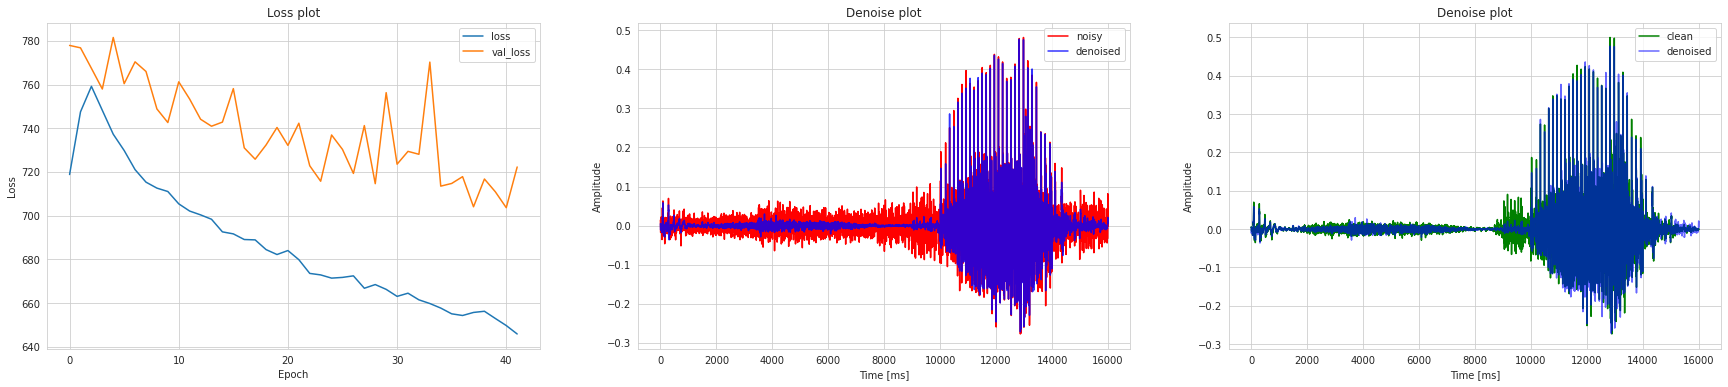

Epoch 43

Train Epoch:43	lr:0.00025	Loss:652.06024170	Time:23.57 m



Validation Loss:727.91253662


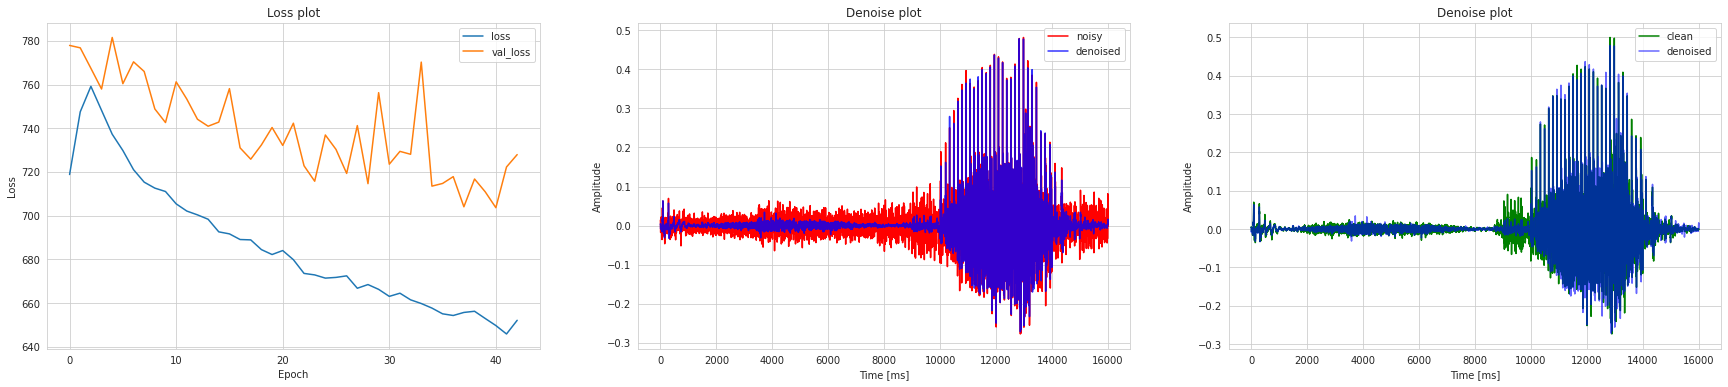

Epoch 44



Train Epoch:44	lr:0.00025	Loss:649.15014648	Time:23.58 m



Validation Loss:706.85681152


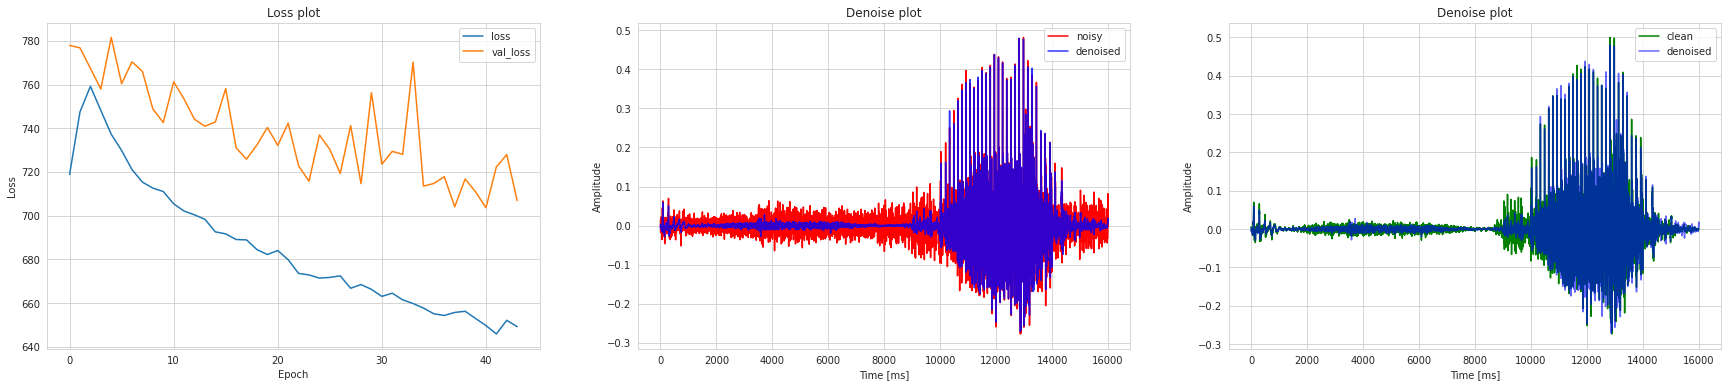

Epoch 45



Train Epoch:45	lr:0.00024	Loss:646.71313477	Time:23.56 m



Validation Loss:703.29083252
===> save to checkpoint at ../log/fine_tuning/wavenetLAB/model_best.pth.tar



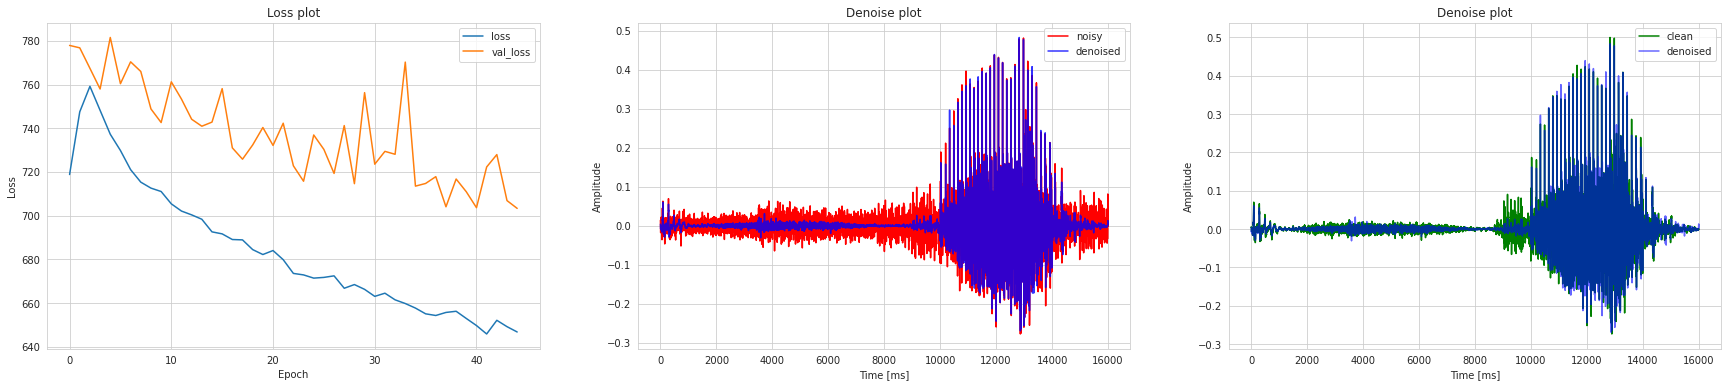

Epoch 46



Train Epoch:46	lr:0.00024	Loss:642.22943115	Time:23.56 m



Validation Loss:707.05059814


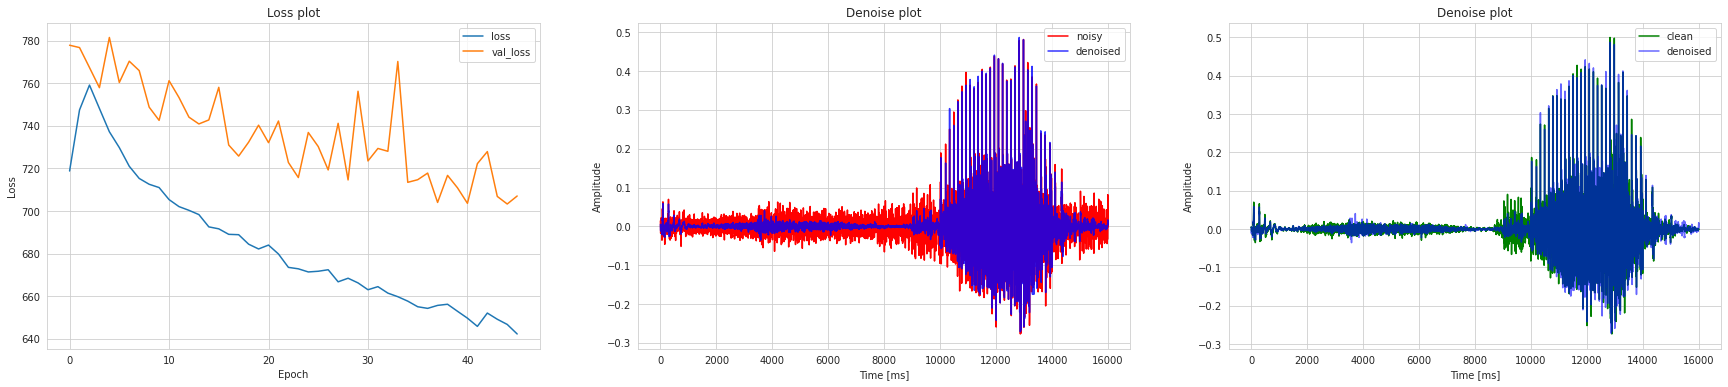

Epoch 47



Train Epoch:47	lr:0.00024	Loss:645.20104980	Time:23.57 m



Validation Loss:706.38439941


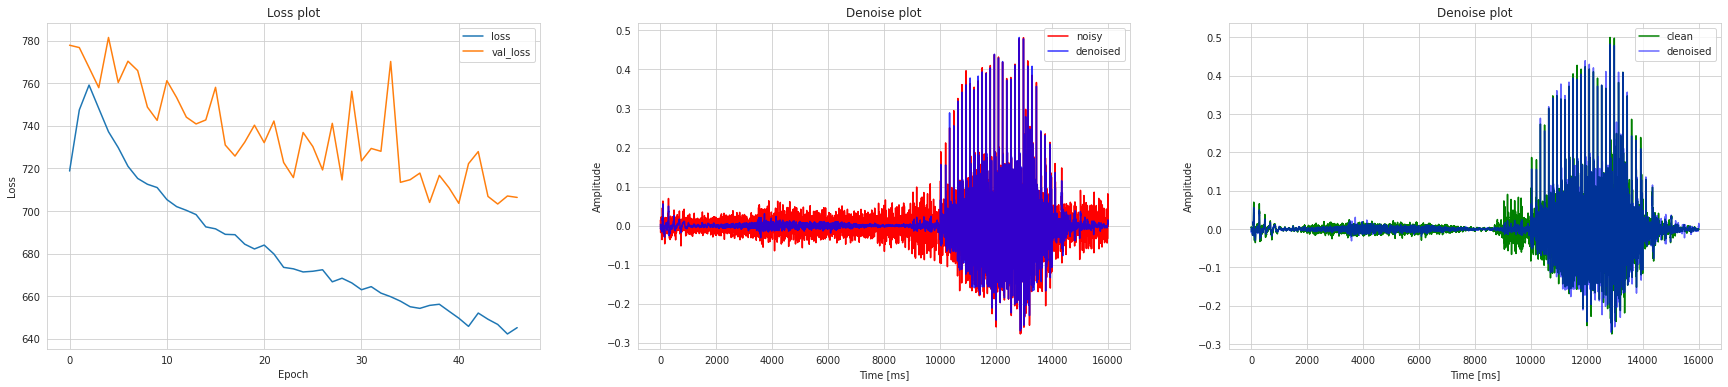

Epoch 48



Train Epoch:48	lr:0.00024	Loss:643.28808594	Time:23.58 m



Validation Loss:716.12591553


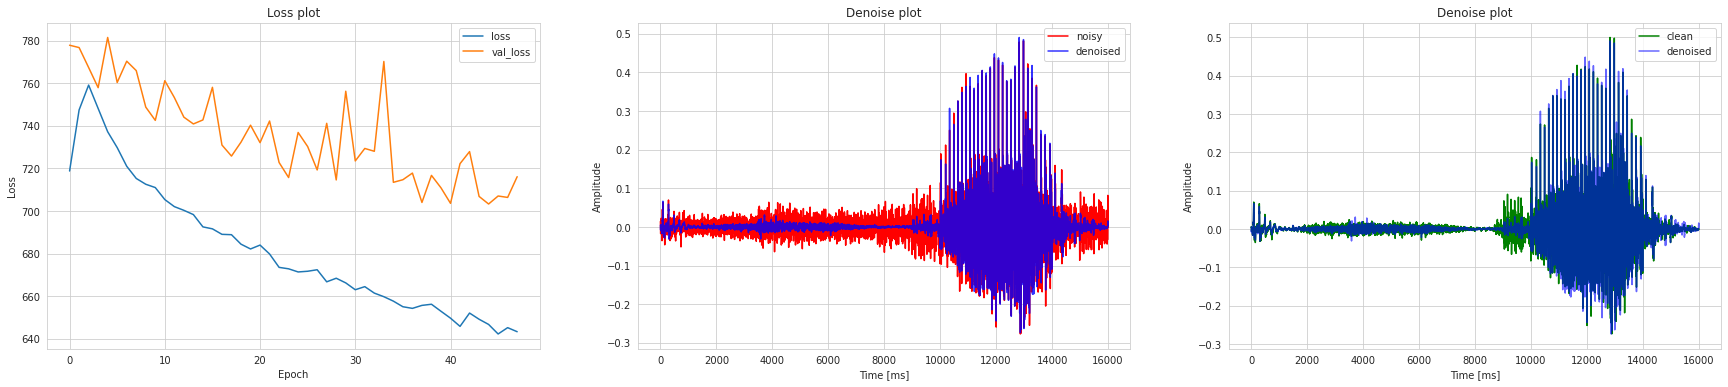

Epoch 49



Train Epoch:49	lr:0.00023	Loss:640.47485352	Time:23.60 m



Validation Loss:713.22100830


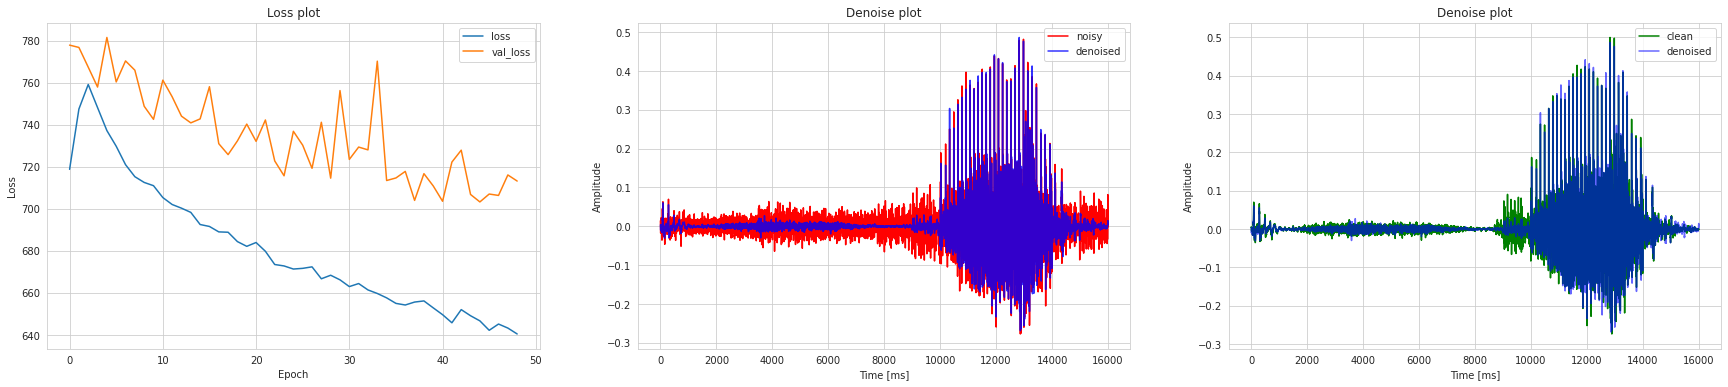

Epoch 50



Train Epoch:50	lr:0.00023	Loss:641.38519287	Time:23.59 m



Validation Loss:701.33489990
===> save to checkpoint at ../log/fine_tuning/wavenetLAB/model_best.pth.tar



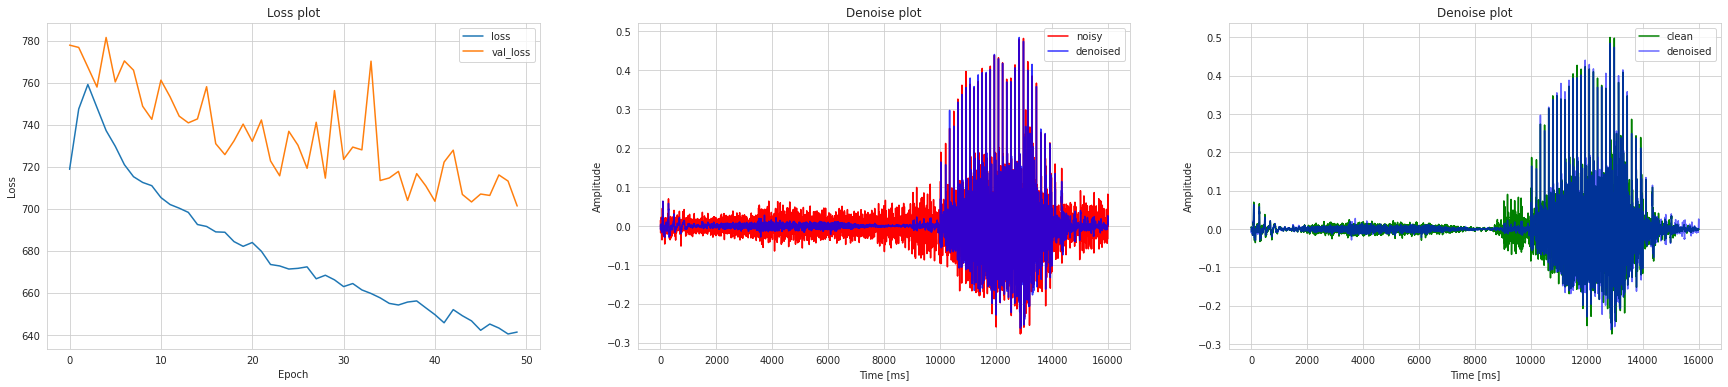

Epoch 51



Train Epoch:51	lr:0.00023	Loss:641.02947998	Time:23.58 m



Validation Loss:706.86120605


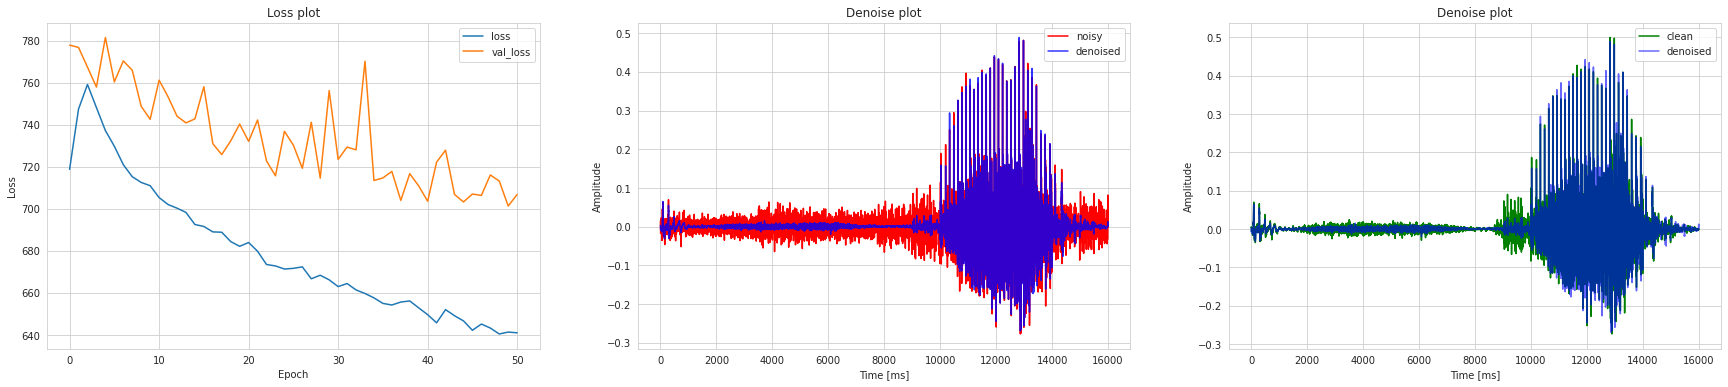

Epoch 52


KeyboardInterrupt: 

In [16]:
train_model(start_epoch = start_epoch, best = best,
            best_epoch = best_epoch, loaders = loaders,
            model = net, classifier = s.__S__, optimizer = optim,
            use_cuda = True, verbose = True, history = history, save = True, log_dir = '../log/fine_tuning/wavenetLAB/')